In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

In [2]:
from lsst.sims.maf.metrics import BaseMetric, Coaddm5Metric, ProperMotionMetric, CrowdingM5Metric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.maps as maps
from lsst.sims.maf.maps import BaseMap
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mb
import lsst.sims.maf.db as db

In [3]:
opsdb = db.OpsimDatabase('fbs_db/baseline_1exp_pairsame_10yrs.db')

In [4]:
# What does the data in a map look like?
filename = os.path.join(os.getenv('SIMS_MAPS_DIR'), 'DustMaps', 'dust_nside_64.npz')
d = np.load(filename)

d['ebvMap']
#np.savez

array([0.28748405, 0.26713541, 0.19383599, ..., 0.142555  , 0.14455602,
       0.15124393])

In [5]:
# Example sort of MSTO depth map
class MagMSTOMap(BaseMap):
    """
    Return the MSTO apparent magnitude (in grizy filters) for each slicepoint. Units of magnitude.
    Uses a healpix map of nside=64. Uses the nearest healpix point for other ra, dec values.
    """
    def __init__(self, filternames=['g', 'r', 'i', 'z',' y']):
        self.mapDir = os.path.join(getPackageDir('sims_maps'), 'StarMaps')
        self.filternames = filternames

    def _readMap(self):
        filename = 'msto_%s_nside_64.npz' % (self.filtername, self.startype)
        mstoMap = np.load(os.path.join(self.mapDir, filename))
        self.msto = {}
        for f in self.filternames:
            self.msto[f] = mstoMap[f]
        self.nside = hp.npix2nside(np.size(self.msto[f]))

    def run(self, slicePoints):
        self._readMap()

        nsideMatch = False
        if 'nside' in slicePoints:
            if slicePoints['nside'] == self.starmapNside:
                slicePoints['msto'] = self.msto
                nsideMatch = True
        # Maybe look at DustMap and EBV to look at other interpolation options?
        if not nsideMatch:
            # Compute the healpix for each slicepoint on the nside=64 grid
            indx = radec2pix(self.nside, slicePoints['ra'], slicePoints['dec'])
            slicePoints['msto'] = self.msto[indx,:]

        return slicePoints

In [11]:
s = slicers.HealpixSlicer(nside=64, useCache=False)
filterlist = ['g', 'r', 'i', 'z', 'y']
crowdingmapList = []
for f in filterlist:
    # Set up stellar density maps, where they now add StarLumFunc_{f} to slicePoints dictionary.
    crowdingmapList.append(maps.StellarDensityMap(filtername=f))
m = BulgeDepthMetric()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [12]:
bundle = mb.MetricBundle(m, s, constraint='night<720', mapsList=crowdingMapList)

In [18]:
g = mb.MetricBundleGroup({0: bundle}, opsdb)
g.runAll()

Querying database SummaryAllProps with constraint night<720 for columns ['fieldDec', 'fieldRA', 'seeingFwhmGeom']
Found 426535 visits
Running:  [0, 'i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


{'SkyMap': 1}

/Users/lynnej/lsst_stack/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


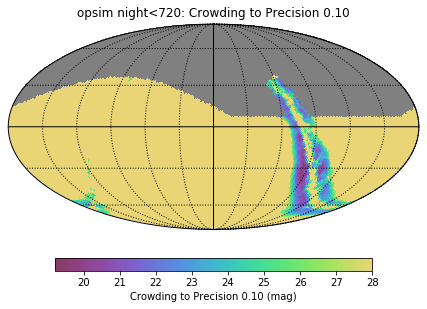

In [19]:
bundle.plot(plotFunc=plots.HealpixSkyMap())

In [26]:
try:
    del BaseMetric.registry['__main__.BulgeDepthMetric']
except KeyError:
    pass

class BulgeDepthMetric(BaseMetric):
    """Evaluate if a field is suitable for measuring main sequence turnoff point.
    """
    def __init(self, filterCol='filter', m5Col='fiveSigmaDepth', seeingCol='seeingFwhmGeom',  
               mjdCol='observationStartLST', filterlist=['g', 'r', 'i', 'z', 'y'],
               photometricUncertainty=0.1, propermotionUncertainty=1.0):
        cols = [filterCol, m5Col, seeingCol, mjdCol]
        self.filterCol = filterCol
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.mjdCol = mjdCol
        maps = 'MagMSTOMap'
        units = ''
        self.photometricUncertainty = photometricUncertainty
        self.propermotionUncertainty = propermotionUncertainty
        self.crowdLimitMetrics = {}
        for f in filterlist:
            self.crowdLimitMetric[f] = CrowdM5Metric(crowding_error=self.photometricUncertainty,
                                                    filtername=f, seeingCol=seeingCol)
        self.coaddMetric = CoaddM5Metric(m5Col=m5Col)
        super().__init__(col=cols, maps=maps, units=units, **kwargs)
    
    def run(self, dataSlice, slicePoint):
        # What is coadded depth?
        coaddLimit = {}
        for f in self.filterlist:
            coaddLimit[f] = self.coaddMetric.run(dataSlice)
        # What is depth at which crowding results in photometric uncertainty greater than photUncert?
        crowdLimit = {}
        for f in self.filterlist:
            crowdLimit[f] = self.crowdLimitMetric[f](dataSlice, slicePoint)
        # Depth at this point in the sky?
        depth = {}
        for f in self.filterlist:
            depth[f] = np.min([crowdLimit[f], coaddLimit[f]])
        # What is proper motion error after 10 years (at MSTO mag in i band)
        propermotionMetric = ProperMotionMetric(m5Col=self.m5Col, mjdCol=self.mjdCol, 
                                                filterCol=self.filterCol, seeingCol=self.seeingCol, 
                                                baseline=10.0, rmag=slicePoint['msto']['i'])
        propmotionError = propermotionMetric.run(dataSlice)
        # Now compare each of these to match Gonzalez_stellarpops_gp metric:
        result = 0
        for f in filterlist:
            if depth[f] > slicePoint['msto'][f]:
                result += 1
        if propmotionError < self.propermotionUncertainty:
            result += 1
        return result    

In [22]:
# Summary metric - foAreaMetric .. Nvisits = threshold, nside = slicer nside. === area reaching your threshold.